# Article classification

## Download data

In [ ]:
!wget -O data.json "https://akela.mendelu.cz/~xvalovic/igracek/articles_titles.json"

--2022-11-05 20:53:14--  https://akela.mendelu.cz/~xvalovic/igracek/articles_titles.json
Resolving akela.mendelu.cz (akela.mendelu.cz)... 195.113.194.135
Connecting to akela.mendelu.cz (akela.mendelu.cz)|195.113.194.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84814849 (81M) [application/json]
Saving to: ‘data.json’

data.json           100%[===================>]  80.89M  52.6MB/s    in 1.5s    

2022-11-05 20:53:16 (52.6 MB/s) - ‘data.json’ saved [84814849/84814849]



In [ ]:
# data manipulation
import pandas as pd
import numpy as np
import json
import re
from collections import Counter
from itertools import chain

# pretty loading bar
from tqdm import tqdm
tqdm.pandas()

# natural language processing
import nltk
import inflect
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

# vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# machine learning
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib

# vizualization
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Configuration

In [ ]:
TEST_SIZE = 0.2
TARGET_DATA = "article_text_en"
LIMIT_ROWS = None

## Load data

In [ ]:
df = pd.DataFrame(json.load(open("data.json")))
df = df.drop(["published_at"], axis=1)
if LIMIT_ROWS:
    df = df[:LIMIT_ROWS]
df

,article_category,article_title_en,article_text_en
0,Unternehmen,Omikron: The pitfalls of the new virus variant,Düsseldorf the chefs of the two leading vaccin...
1,Meinung,Fed boss Powell's warning about inflation: Eve...,Francfurt is likely to become the word of the ...
2,Technologie,"Biontech, Moderna and AstraZeneca: How does th...","Biontech, moderna, Astra-Zeneca or johnson and..."
3,Finanzen,Economist ranking: Tel Aviv replaces Paris as ...,London the Israeli coastal metropolis tel aviv...
4,Politik,More innovation through more data: EU celebrat...,"In the future, the rapidly increasing data vol..."
...,...,...,...
45175,Unternehmen,VW daughter,Lkw and machine builders are coming forward fa...
45176,Unternehmen,Bestselling author Marc Elsberg on gene manipu...,Düsseldorf his book blackout about a cyberatta...
45177,Politik,Ifo Employment Scoreboard,Berlin after an uninterrupted increase since m...
45178,Meinung,Comment on the SPD,"On Sunday, the German Social Democraty may not..."


## Preprocessing

In [ ]:
def preprocess(text, stopwords=[]):
    text = text.lower()                                # to lowercase
    text = re.sub("[^a-z-äöüß]", " ", text)            # remove non-alphabet characters
    text = re.sub("[ ]{2,}", " ", text)                # remove more than 2 spaces in a row 
    text = text.strip()                                # remove spaces at the beginning and at the end
    
    wnl = nltk.stem.WordNetLemmatizer()
    tokenized = []

    for token in nltk.word_tokenize(text):
        token = wnl.lemmatize(token)                    # lemmatize
        if token not in stopwords and len(token) > 1:   # stopwords
            tokenized.append(token)

    return tokenized    

In [ ]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords.extend(["also", "thus"])
stopwords.extend(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
stopwords.extend(["first", "second", "third"])
stopwords.extend(["percent", "said", "year", "would", "new", "ha"])
stopwords.extend(["wa", "say", "could", "already", "want", "however"])
stopwords.extend([inflect.engine().number_to_words(i) for i in range(100)])

In [ ]:
df["tokenized"] = df[TARGET_DATA].progress_apply(preprocess, stopwords=stopwords)
df

100%|██████████| 45180/45180 [02:04<00:00, 363.35it/s]


,article_category,article_title_en,article_text_en,tokenized
0,Unternehmen,Omikron: The pitfalls of the new virus variant,Düsseldorf the chefs of the two leading vaccin...,"[düsseldorf, chef, leading, vaccination, manuf..."
1,Meinung,Fed boss Powell's warning about inflation: Eve...,Francfurt is likely to become the word of the ...,"[francfurt, likely, become, word, capital, mar..."
2,Technologie,"Biontech, Moderna and AstraZeneca: How does th...","Biontech, moderna, Astra-Zeneca or johnson and...","[biontech, moderna, astra-zeneca, johnson, joh..."
3,Finanzen,Economist ranking: Tel Aviv replaces Paris as ...,London the Israeli coastal metropolis tel aviv...,"[london, israeli, coastal, metropolis, tel, av..."
4,Politik,More innovation through more data: EU celebrat...,"In the future, the rapidly increasing data vol...","[future, rapidly, increasing, data, volume, co..."
...,...,...,...,...
45175,Unternehmen,VW daughter,Lkw and machine builders are coming forward fa...,"[lkw, machine, builder, coming, forward, faste..."
45176,Unternehmen,Bestselling author Marc Elsberg on gene manipu...,Düsseldorf his book blackout about a cyberatta...,"[düsseldorf, book, blackout, cyberattack, powe..."
45177,Politik,Ifo Employment Scoreboard,Berlin after an uninterrupted increase since m...,"[berlin, uninterrupted, increase, since, mai, ..."
45178,Meinung,Comment on the SPD,"On Sunday, the German Social Democraty may not...","[sunday, german, social, democraty, may, play,..."


## Frequency analysis

In [ ]:
counter = Counter(list(chain.from_iterable(df["tokenized"])))
counter.most_common(15)

[('euro', 45100),
 ('company', 36529),
 ('market', 30262),
 ('time', 29366),
 ('bank', 26838),
 ('billion', 25597),
 ('german', 23346),
 ('million', 22983),
 ('group', 22980),
 ('country', 22950),
 ('government', 20814),
 ('according', 19922),
 ('state', 19546),
 ('germany', 18033),
 ('business', 16219)]

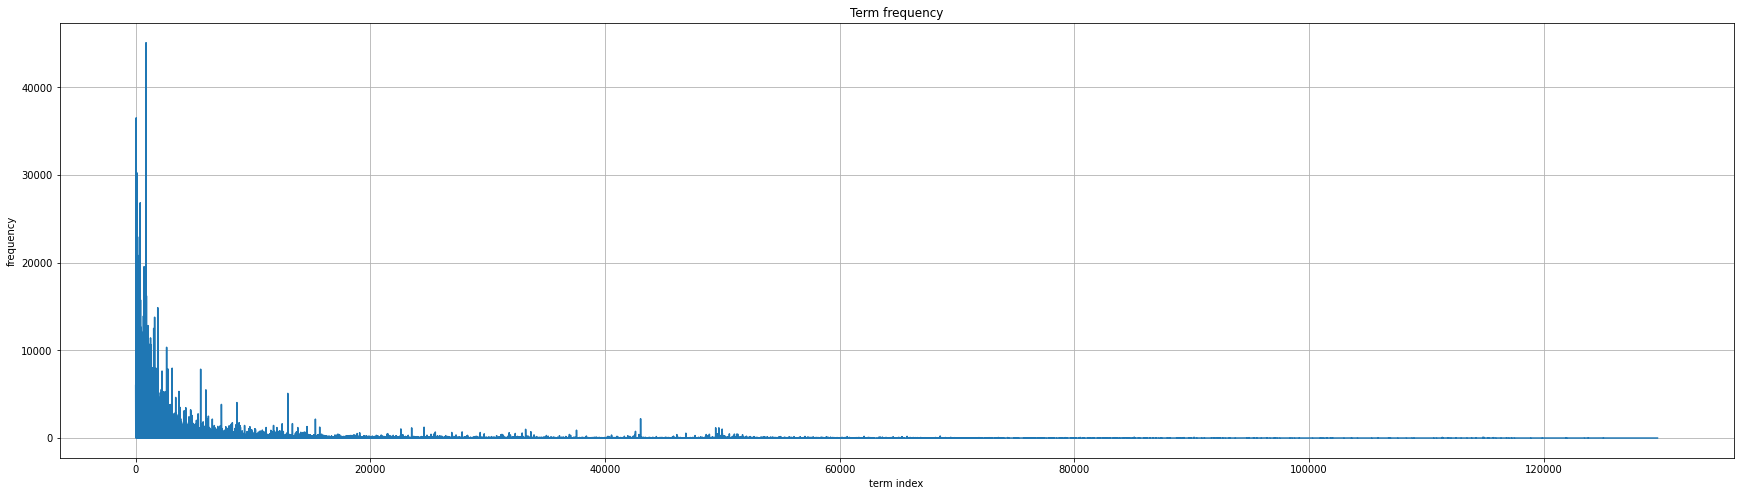

In [ ]:
plt.figure(figsize=(30,8))
plt.title("Term frequency")
plt.plot(range(len(counter.values())), list(counter.values()), '-')
plt.xlabel('term index')
plt.ylabel('frequency')
plt.grid()

## Vectorization

In [ ]:
def convert_term_list_to_string(token_list):
    if isinstance(token_list, list):
        return ' '.join(token_list)
    
df["tokenized"] = df["tokenized"].progress_apply(convert_term_list_to_string)   # convert list to string
df[df["tokenized"].str.contains("") == False]                                   # drop empty strings
df

100%|██████████| 45180/45180 [00:00<00:00, 185130.50it/s]


,article_category,article_title_en,article_text_en,tokenized
0,Unternehmen,Omikron: The pitfalls of the new virus variant,Düsseldorf the chefs of the two leading vaccin...,düsseldorf chef leading vaccination manufactur...
1,Meinung,Fed boss Powell's warning about inflation: Eve...,Francfurt is likely to become the word of the ...,francfurt likely become word capital market tr...
2,Technologie,"Biontech, Moderna and AstraZeneca: How does th...","Biontech, moderna, Astra-Zeneca or johnson and...",biontech moderna astra-zeneca johnson johnson ...
3,Finanzen,Economist ranking: Tel Aviv replaces Paris as ...,London the Israeli coastal metropolis tel aviv...,london israeli coastal metropolis tel aviv acc...
4,Politik,More innovation through more data: EU celebrat...,"In the future, the rapidly increasing data vol...",future rapidly increasing data volume company ...
...,...,...,...,...
45175,Unternehmen,VW daughter,Lkw and machine builders are coming forward fa...,lkw machine builder coming forward faster rest...
45176,Unternehmen,Bestselling author Marc Elsberg on gene manipu...,Düsseldorf his book blackout about a cyberatta...,düsseldorf book blackout cyberattack power gri...
45177,Politik,Ifo Employment Scoreboard,Berlin after an uninterrupted increase since m...,berlin uninterrupted increase since mai ifo em...
45178,Meinung,Comment on the SPD,"On Sunday, the German Social Democraty may not...",sunday german social democraty may play leadin...


In [ ]:
# convert article categories to numbers
categories = {}
for (category, id) in enumerate(df["article_category"].unique()):
    categories[id] = category
df["category_id"] = df["article_category"].progress_apply(categories.get)

100%|██████████| 45180/45180 [00:00<00:00, 779663.01it/s]


In [ ]:
tf_idf = TfidfVectorizer()
tf_idf.fit_transform(df["tokenized"])

# split data to training and testing
x_training, x_testing, y_training, y_testing = train_test_split(
    df["tokenized"], df["category_id"], test_size = TEST_SIZE)

# vectorize
x_training = tf_idf.transform(x_training)
x_testing = tf_idf.transform(x_testing)

## Machine learning

In [ ]:
# Naive Bayes
bayes_model = MultinomialNB()
bayes_model.fit(x_training, y_training)

bayes_prediction = bayes_model.predict(x_testing)

In [ ]:
# Logistic regresion
#lr_model = LogisticRegression(solver = "saga", C=10, penalty="elasticnet", l1_ratio=0.8)
lr_model = LogisticRegression(solver = "liblinear", penalty="l2", C=10)
lr_model.fit(x_training, y_training)

lr_prediction = lr_model.predict(x_testing)

## Results

In [ ]:
result = pd.DataFrame(columns=["y_testing", "bayes_predict", "lr_predict"])
result["y_testing"] = y_testing
result["bayes_predict"] = bayes_prediction
result["lr_predict"] = lr_prediction

total_res = len(result)
bayes_correct_res = 0
lr_correct_res = 0

for index, row in result.iterrows():
    if row['y_testing'] == row['bayes_predict']:
      bayes_correct_res += 1
    if row["y_testing"] == row["lr_predict"]:
      lr_correct_res += 1

print("==== RESULTS ====")
print(f"Dataset size: {len(df)}")
print(f"Testing size: {TEST_SIZE * 100} %\n")
print(f"Naive Bayes results:")
print(f"    {bayes_correct_res} / {total_res}")
print(f"    accurancy: {bayes_correct_res * 100 / total_res} %\n")
print(f"Logistic regresion result:")
print(f"    {lr_correct_res} / {total_res}")
print(f"    accurancy: {lr_correct_res * 100 / total_res} %")

==== RESULTS ====
Dataset size: 45180
Testing size: 20.0 %

Naive Bayes results:
    6189 / 9036
    accurancy: 68.49269588313413 %

Logistic regresion result:
    7487 / 9036
    accurancy: 82.85745905267818 %


In [ ]:
print("\n==== SAVING MODELS ====")
print(joblib.dump(bayes_model, TARGET_DATA + "_bayes.joblib"))
print(joblib.dump(lr_model, TARGET_DATA + "_logistic_regresion.joblib"))
with open("categories.json", mode="w") as f:
    json.dump(categories, f)
print("['categories.json']")


==== SAVING MODELS ====
['article_text_en_bayes.joblib']
['article_text_en_logistic_regresion.joblib']
['categories.json']


## Trained model - experimental usage

In [ ]:
!wget "https://akela.mendelu.cz/~xchatrny/soubory/ktma/experiment_text.json"
!wget "https://akela.mendelu.cz/~xchatrny/soubory/ktma/experiment_text.json"

--2022-11-05 21:05:40--  https://akela.mendelu.cz/~xchatrny/soubory/ktma/experiment_text.json
Resolving akela.mendelu.cz (akela.mendelu.cz)... 195.113.194.135
Connecting to akela.mendelu.cz (akela.mendelu.cz)|195.113.194.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1774 (1.7K) [application/json]
Saving to: ‘experiment_text.json’

experiment_text.jso 100%[===================>]   1.73K  --.-KB/s    in 0s      

2022-11-05 21:05:41 (192 MB/s) - ‘experiment_text.json’ saved [1774/1774]

--2022-11-05 21:05:41--  https://akela.mendelu.cz/~xchatrny/soubory/ktma/experiment_text.json
Resolving akela.mendelu.cz (akela.mendelu.cz)... 195.113.194.135
Connecting to akela.mendelu.cz (akela.mendelu.cz)|195.113.194.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1774 (1.7K) [application/json]
Saving to: ‘experiment_text.json.1’

experiment_text.jso 100%[===================>]   1.73K  --.-KB/s    in 0s      

2022-11-05 21:05:42 (195 MB/s) 

In [ ]:
data = pd.DataFrame(json.load(open("experiment_text.json")))
model = "logistic_regresion"  # logistic_regresion | bayes

loaded_model = joblib.load(f"{TARGET_DATA}_{model}.joblib")

def get_category_by_id(id):
    categories = json.load(open('categories.json'))
    keys = list(categories.keys())
    vals = list(categories.values())
    return keys[vals.index(id)]

data["tokenized"] = data["data"].apply(preprocess, stopwords=stopwords)
data["tokenized"] = data["tokenized"].apply(convert_term_list_to_string)

vectors = tf_idf.transform(data["tokenized"])
category_ids = loaded_model.predict(vectors)

data["ai_result"] = [get_category_by_id(category_id) for category_id in category_ids]
data = data[["data", "tokenized", "expected_result", "ai_result"]]
data

,data,tokenized,expected_result,ai_result
0,On the plane on the way back from Beijing to B...,plane way back beijing berlin olaf scholz seem...,Meinung,Finanzen
1,Düsseldorf The German oil and gas producer Win...,düsseldorf german oil gas producer wintershall...,Unternehmen,Unternehmen
